In [1]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Conv2D, Reshape, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
import os
import pandas as pd
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from tensorflow.keras import metrics
import tensorflow

2024-04-21 03:14:50.553681: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-21 03:14:50.628430: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-21 03:14:51.973647: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
trainDir = '/home/hice1/ychen3606/scratch/mlproject/facial_expression_dataset_splited/train'
validDir = '/home/hice1/ychen3606/scratch/mlproject/facial_expression_dataset_splited/validate'
testDir = '/home/hice1/ychen3606/scratch/mlproject/facial_expression_dataset_splited/test'

In [3]:
def createDF(dir):
    images = []
    labels = []
    for label in os.listdir(dir):
        label_path = os.path.join(dir, label)
        if os.path.isdir(label_path):
            for image in os.listdir(label_path):
                image_path = os.path.join(label_path, image)
                if os.path.isfile(image_path):
                    images.append(image_path)
                    labels.append(label)
    return images, labels

In [4]:
trainDF = pd.DataFrame()
trainDF['image'], trainDF['label'] = createDF(trainDir)

In [5]:
validDF = pd.DataFrame()
validDF['image'], validDF['label'] = createDF(validDir)

In [6]:
testDF = pd.DataFrame()
testDF['image'], testDF['label'] = createDF(testDir)

In [7]:
def extractFeatures(images):
  features = []
  for image in tqdm(images):
    img = load_img(image, color_mode='grayscale')
    img = img_to_array(img)
    features.append(img)
  features = np.array(features)
  features = features.reshape(len(features), 48, 48, 1)
  return features

In [8]:
trainFeatures = extractFeatures(trainDF['image'])

  0%|          | 0/24502 [00:00<?, ?it/s]

In [9]:
validFeatures = extractFeatures(validDF['image'])

  0%|          | 0/4319 [00:00<?, ?it/s]

In [10]:
testFeatures = extractFeatures(testDF['image'])

  0%|          | 0/7066 [00:00<?, ?it/s]

In [11]:
x_train = trainFeatures/255.0
x_valid = validFeatures/255.0
x_test = testFeatures/255.0

In [12]:
labelEncoder = LabelEncoder()
labelEncoder.fit(trainDF['label'])

LabelEncoder()

In [13]:
y_train = labelEncoder.transform(trainDF['label'])
y_valid = labelEncoder.transform(validDF['label'])
y_test = labelEncoder.transform(testDF['label'])

In [14]:
y_train = to_categorical(y_train, num_classes = 7)
y_valid = to_categorical(y_valid, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

In [15]:
#Note: maybe try to freeze some layers for transfer learning

In [16]:
import h5py

In [17]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [18]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

input_tensor = Input(shape=(48, 48, 1))
x = Conv2D(3, (3, 3), padding='same')(input_tensor)
x = Reshape((48, 48, 3))(x)
x = base_model(x)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)  # Batch Normalization after feature extraction
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # L2 Regularization
x = Dropout(0.5)(x)  # Dropout to prevent co-adaptation of neurons
predictions = Dense(7, activation='softmax')(x)
model = Model(inputs=input_tensor, outputs=predictions)


2024-04-21 03:15:17.348815: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31083 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:af:00.0, compute capability: 7.0


In [19]:
class F1Score(tensorflow.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = metrics.Precision()
        self.recall = metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tensorflow.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [20]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', 
                       metrics.Precision(name='precision'),
                       metrics.Recall(name='recall'),
                       # tfa.metrics.F1Score(num_classes=7, average='weighted'),
                       metrics.AUC(name='AUCPR', curve='PR', multi_label=False),
                       metrics.AUC(name='AUCROC', curve='ROC',multi_label=False),
                       F1Score()])

In [21]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 3)         30        
                                                                 
 reshape (Reshape)           (None, 48, 48, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                               

In [23]:
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.002,
                               patience=3,
                               mode='min',
                               restore_best_weights=True)

In [24]:
# history = model.fit(
#     x=x_train,
#     y=y_train,
#     batch_size=32,
#     epochs=15,
#     validation_data=(x_valid, y_valid),
#     callbacks=[early_stopping]  # Add early stopping here
# )

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),  # Use the data generator here
    steps_per_epoch=len(x_train) // 32,  # Number of steps per epoch
    epochs=15,
    validation_data=(x_valid, y_valid),
    callbacks=[early_stopping]  # Early stopping callback
)

model.save('fcr_cnn_mar3_mine_on_orig.h5')

Epoch 1/15


2024-04-21 03:15:21.593058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-04-21 03:15:38.375032: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-04-21 03:15:38.952044: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x2aac10030510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-21 03:15:38.952082: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2024-04-21 03:15:38.959481: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-21 03:15:39.188872

764/765 [============================>.] - ETA: 0s - loss: 6.1551 - accuracy: 0.2722 - precision: 0.3335 - recall: 0.1247 - AUCPR: 0.2452 - AUCROC: 0.6578 - f1_score: 0.1815

/home/hice1/ychen3606/scratch/pace-env/lib/python3.9/site-packages/keras/engine/training.py:2448: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


765/765 [==============================] - 77s 41ms/step - loss: 6.1540 - accuracy: 0.2723 - precision: 0.3338 - recall: 0.1247 - AUCPR: 0.2453 - AUCROC: 0.6579 - f1_score: 0.1816 - val_loss: 5.7184 - val_accuracy: 0.1873 - val_precision: 0.2059 - val_recall: 0.0194 - val_AUCPR: 0.1796 - val_AUCROC: 0.6039 - val_f1_score: 0.0355
Epoch 2/15
765/765 [==============================] - 29s 38ms/step - loss: 4.6741 - accuracy: 0.3716 - precision: 0.6054 - recall: 0.1573 - AUCPR: 0.3837 - AUCROC: 0.7561 - f1_score: 0.2497 - val_loss: 3.9211 - val_accuracy: 0.4730 - val_precision: 0.7007 - val_recall: 0.2721 - val_AUCPR: 0.5300 - val_AUCROC: 0.8344 - val_f1_score: 0.3919
Epoch 3/15
765/765 [==============================] - 29s 38ms/step - loss: 3.6048 - accuracy: 0.4270 - precision: 0.6649 - recall: 0.2088 - AUCPR: 0.4577 - AUCROC: 0.8001 - f1_score: 0.3178 - val_loss: 3.0313 - val_accuracy: 0.4990 - val_precision: 0.6801 - val_recall: 0.3209 - val_AUCPR: 0.5467 - val_AUCROC: 0.8463 - val_f1

In [25]:
df = pd.DataFrame(model.history.history)
df

,loss,accuracy,precision,recall,AUCPR,AUCROC,f1_score,val_loss,val_accuracy,val_precision,val_recall,val_AUCPR,val_AUCROC,val_f1_score
0,6.153982,0.272293,0.333771,0.124724,0.245280,0.657863,0.181591,5.718439,0.187312,0.205882,0.019449,0.179573,0.603910,0.035540
1,4.674096,0.371557,0.605412,0.157254,0.383685,0.756127,0.249659,3.921062,0.473026,0.700656,0.272054,0.530006,0.834449,0.391928
2,3.604819,0.426972,0.664888,0.208786,0.457725,0.800071,0.317783,3.031272,0.498958,0.680079,0.320908,0.546685,0.846339,0.436055
3,2.773432,0.464160,0.675283,0.246629,0.501397,0.825084,0.361301,2.419987,0.511461,0.695773,0.346840,0.550738,0.850990,0.462917
4,2.203267,0.481406,0.687423,0.272047,0.526534,0.837010,0.389823,1.848148,0.541561,0.766796,0.319750,0.607378,0.874411,0.451307
5,1.843175,0.492644,0.690996,0.284757,0.540171,0.843648,0.403311,1.886930,0.517249,0.691035,0.299838,0.515246,0.848371,0.418214
6,1.612460,0.506048,0.702685,0.303760,0.559205,0.850715,0.424161,1.475786,0.521649,0.729521,0.327854,0.593482,0.866771,0.452396
7,1.490684,0.507846,0.709696,0.304209,0.561384,0.852919,0.425870,1.350828,0.558000,0.738841,0.360269,0.614346,0.880045,0.484358
8,1.396716,0.525746,0.704616,0.323743,0.572465,0.860877,0.443648,1.249365,0.557305,0.768559,0.366752,0.635725,0.886607,0.496552
9,1.347085,0.530854,0.710348,0.333837,0.581332,0.864519,0.454212,1.336797,0.552674,0.730443,0.378328,0.627606,0.880225,0.498475


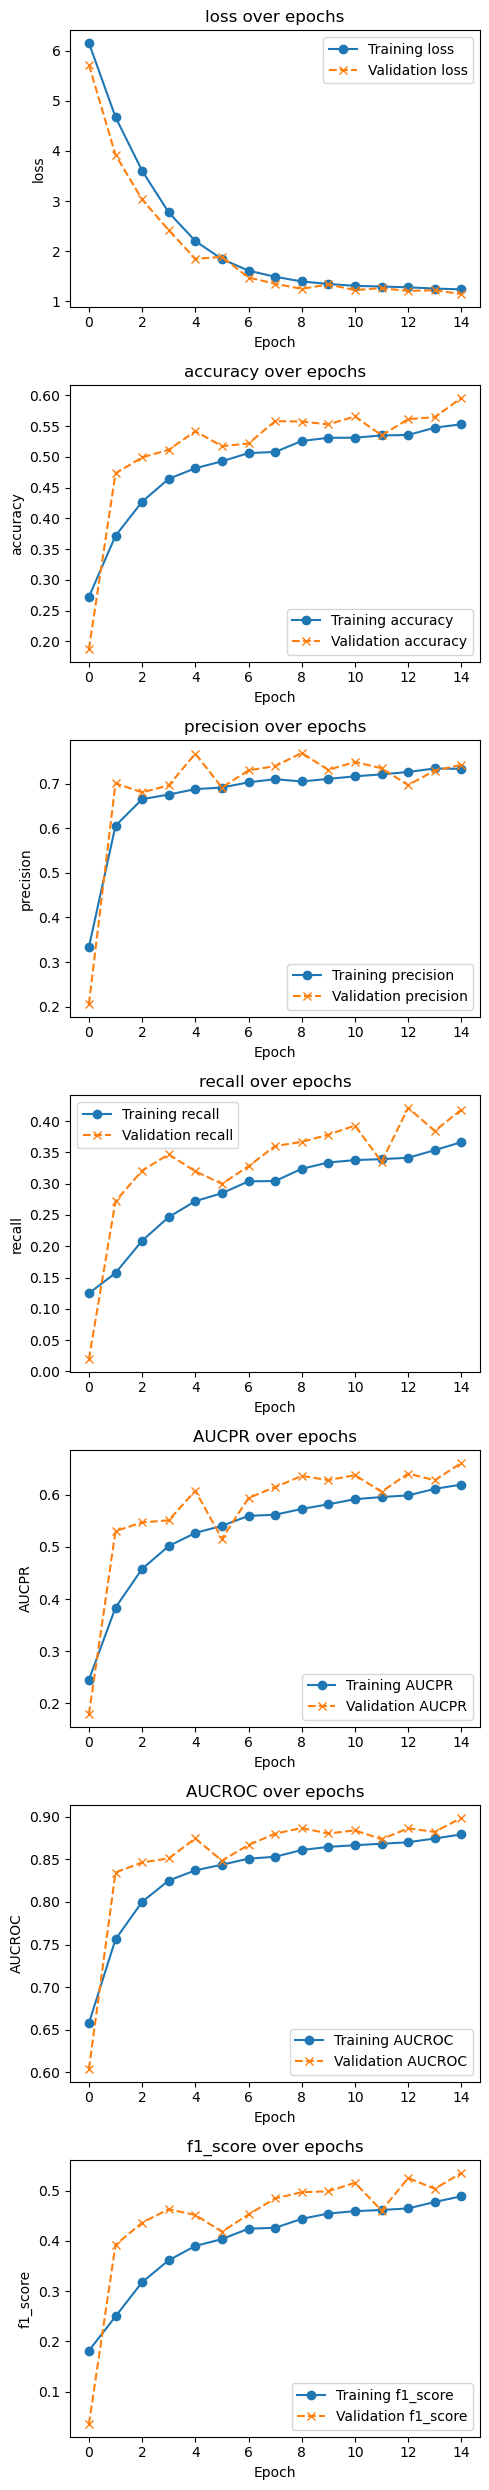

In [26]:
# Create a figure with 7 subplots (one for each metric)
fig, axs = plt.subplots(7, 1, figsize=(5, 25))  # 7 rows, 1 column

# List of metrics to plot
metrics = ['loss', 'accuracy', 'precision', 'recall', 'AUCPR', 'AUCROC','f1_score']
# take out 'f1_score'

for i, metric in enumerate(metrics):
    # Plot training metric
    axs[i].plot(df.index, df[metric], label=f'Training {metric}', marker='o')

    # Plot validation metric
    val_metric = f'val_{metric}'
    axs[i].plot(df.index, df[val_metric], label=f'Validation {metric}', linestyle='--', marker='x')

    axs[i].set_title(f'{metric} over epochs')
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel(metric)
    axs[i].legend()

# Adjust layout for better fit
plt.tight_layout()
plt.show()

In [27]:
test_scores = model.evaluate(x_test, y_test)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])
print("Test precision:", test_scores[2])
print("Test recall:", test_scores[3])
print("Test AUCPR:", test_scores[4])
print("Test AUCROC:", test_scores[5])
print("Test F1 Score:", test_scores[6])

 19/221 [=>............................] - ETA: 1s - loss: 1.4908 - accuracy: 0.4786 - precision: 0.5753 - recall: 0.2829 - AUCPR: 0.4575 - AUCROC: 0.8189 - f1_score: 0.3793

/home/hice1/ychen3606/scratch/pace-env/lib/python3.9/site-packages/keras/engine/training.py:2448: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


221/221 [==============================] - 2s 10ms/step - loss: 1.1430 - accuracy: 0.5971 - precision: 0.7352 - recall: 0.4311 - AUCPR: 0.6628 - AUCROC: 0.8988 - f1_score: 0.5435
Test loss: 1.142983078956604
Test accuracy: 0.597084641456604
Test precision: 0.7352160215377808
Test recall: 0.43107840418815613
Test AUCPR: 0.6627774834632874
Test AUCROC: 0.8988179564476013
Test F1 Score: 0.543491780757904
